In [49]:
import os
import numpy as np
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import ResNet152,ResNet50,VGG19,InceptionV3,MobileNetV3Large
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score,f1_score,precision_score,recall_score,roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

In [50]:
def load_images_from_folder(base_path,subpath):
    datasets = {'healthy': {'images': [], 'labels': []},
                'parkinson': {'images': [], 'labels': []}}
    
    for dataset in ['testing', 'training']:
        dataset_path = os.path.join(base_path, subpath, dataset)
        
        for class_label, class_folder in enumerate(['healthy', 'parkinson']):
            class_path = os.path.join(dataset_path, class_folder)
            
            if os.path.isdir(class_path):
                for filename in os.listdir(class_path):
                    img_path = os.path.join(class_path, filename)
                    
                    try:
                        with Image.open(img_path) as img:
                            img = img.convert('RGB')
                            img = img.resize((224, 224))  # Adjust size as needed
                            img_array = np.array(img)
                            datasets[class_folder]['images'].append(img_array)
                            datasets[class_folder]['labels'].append(class_label)
                    except Exception as e:
                        print(f"Error loading image {img_path}: {e}")
    
    # Convert lists to numpy arrays
    for dataset in datasets:
        datasets[dataset]['images'] = np.array(datasets[dataset]['images'])
        datasets[dataset]['labels'] = np.array(datasets[dataset]['labels'])
    
    return datasets


In [51]:
# Usage
base_path = 'D:\Projects\Parkinsons_disease\image_model_v2\data'
datasets_spiral = load_images_from_folder(base_path,'spiral')

# Access healthy and parkinson data separately
X_healthy_spiral, y_healthy_spiral = datasets_spiral['healthy']['images'], datasets_spiral['healthy']['labels']
X_parkinson_spiral, y_parkinson_spiral = datasets_spiral['parkinson']['images'], datasets_spiral['parkinson']['labels']

print(f"Loaded {len(X_healthy_spiral)} healthy images and {len(X_parkinson_spiral)} parkinson images of spiral")
print(f"Image shape: {X_healthy_spiral[0].shape}")
print(f"Number of classes: {len(np.unique(np.concatenate([y_healthy_spiral, y_parkinson_spiral])))}")

Loaded 51 healthy images and 51 parkinson images of spiral
Image shape: (224, 224, 3)
Number of classes: 2


In [52]:
X = np.concatenate([X_healthy_spiral,X_parkinson_spiral],axis=0)
y = np.concatenate([y_healthy_spiral,y_parkinson_spiral],axis=0)
print(f"{X.shape},{y.shape}")

(102, 224, 224, 3),(102,)


In [53]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.1,random_state=0)

In [54]:
print(f"train shape : {x_train.shape},{y_train.shape}")
print(f"val shape   : {x_val.shape},{y_val.shape}")
print(f"test shape  : {x_test.shape},{y_test.shape}")

train shape : (72, 224, 224, 3),(72,)
val shape   : (9, 224, 224, 3),(9,)
test shape  : (21, 224, 224, 3),(21,)


1


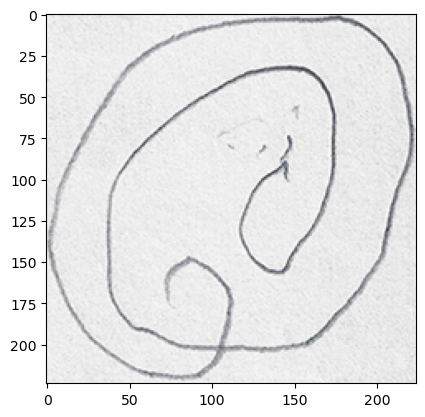

In [55]:
i =8
plt.imshow(x_train[i])
print(y_train[i])

# ResNet152

In [56]:
base_model = ResNet152(weights='imagenet',include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce spatial dimensions
x = Dense(1024, activation='relu')(x)  # Dense layer for feature extraction
predictions = Dense(1, activation='sigmoid')(x)  # Output layer

resnet152_model = Model(inputs=base_model.input, outputs=predictions)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
for layer in base_model.layers:
    layer.trainable = False
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
resnet152_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [57]:
history = resnet152_model.fit(x_train,y_train,epochs=100,batch_size=12,validation_data=(x_val,y_val),callbacks=[early_stopping])

Epoch 1/100
6/6 [==============================] - 22s 2s/step - loss: 0.6321 - accuracy: 0.7083 - val_loss: 0.4400 - val_accuracy: 0.5556
Epoch 2/100
6/6 [==============================] - 8s 1s/step - loss: 0.5770 - accuracy: 0.6667 - val_loss: 0.5211 - val_accuracy: 0.7778
Epoch 3/100
6/6 [==============================] - 7s 1s/step - loss: 0.4407 - accuracy: 0.7917 - val_loss: 0.2999 - val_accuracy: 0.8889
Epoch 4/100
6/6 [==============================] - 6s 1s/step - loss: 0.3487 - accuracy: 0.8611 - val_loss: 0.3592 - val_accuracy: 0.8889
Epoch 5/100
6/6 [==============================] - 7s 1s/step - loss: 0.2899 - accuracy: 0.8472 - val_loss: 0.3061 - val_accuracy: 0.8889
Epoch 6/100
6/6 [==============================] - 7s 1s/step - loss: 0.2575 - accuracy: 0.9167 - val_loss: 0.2569 - val_accuracy: 0.8889
Epoch 7/100
6/6 [==============================] - 7s 1s/step - loss: 0.2444 - accuracy: 0.9167 - val_loss: 0.2636 - val_accuracy: 0.8889
Epoch 8/100
6/6 [================

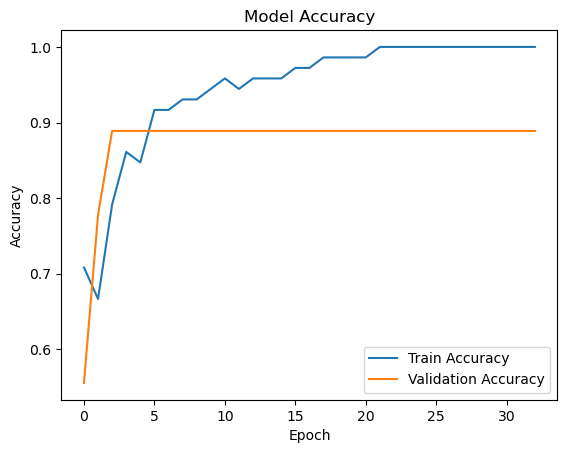

In [58]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

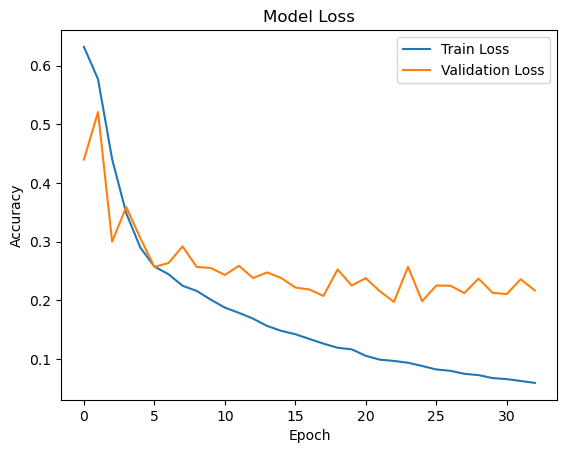

In [59]:
# Plot training & validation accuracy
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ResNet50

In [60]:
base_model = ResNet50(weights='imagenet',include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce spatial dimensions
x = Dense(1024, activation='relu')(x)  # Dense layer for feature extraction
predictions = Dense(1, activation='sigmoid')(x)  # Output layer

resnet50_model = Model(inputs=base_model.input, outputs=predictions)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

for layer in base_model.layers:
    layer.trainable = False

resnet50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [61]:
history = resnet50_model.fit(x_train,y_train,epochs=100,batch_size=12,validation_data=(x_val,y_val),callbacks=[early_stopping])

Epoch 1/100
6/6 [==============================] - 8s 713ms/step - loss: 0.7003 - accuracy: 0.5417 - val_loss: 0.6622 - val_accuracy: 0.5556
Epoch 2/100
6/6 [==============================] - 3s 436ms/step - loss: 0.5081 - accuracy: 0.7361 - val_loss: 0.2834 - val_accuracy: 0.8889
Epoch 3/100
6/6 [==============================] - 3s 444ms/step - loss: 0.3815 - accuracy: 0.8472 - val_loss: 0.2966 - val_accuracy: 0.8889
Epoch 4/100
6/6 [==============================] - 3s 443ms/step - loss: 0.3547 - accuracy: 0.8194 - val_loss: 0.2676 - val_accuracy: 0.8889
Epoch 5/100
6/6 [==============================] - 3s 444ms/step - loss: 0.3276 - accuracy: 0.8750 - val_loss: 0.2397 - val_accuracy: 0.8889
Epoch 6/100
6/6 [==============================] - 3s 431ms/step - loss: 0.2987 - accuracy: 0.8611 - val_loss: 0.2555 - val_accuracy: 0.8889
Epoch 7/100
6/6 [==============================] - 3s 466ms/step - loss: 0.2835 - accuracy: 0.8611 - val_loss: 0.2237 - val_accuracy: 0.8889
Epoch 8/100
6

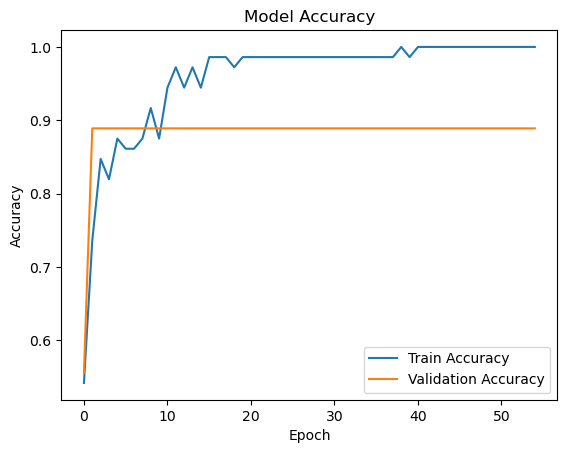

In [62]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

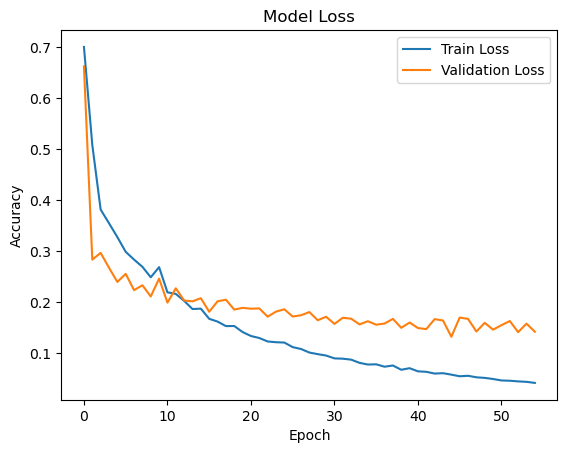

In [63]:
# Plot training & validation accuracy
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# VGG19

In [64]:
base_model = VGG19(weights='imagenet',include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce spatial dimensions
x = Dense(1024, activation='relu')(x)  # Dense layer for feature extraction
predictions = Dense(1, activation='sigmoid')(x)  # Output layer

vgg_model = Model(inputs=base_model.input, outputs=predictions)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

for layer in base_model.layers:
    layer.trainable = False

vgg_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [65]:
history = vgg_model.fit(x_train,y_train,epochs=100,batch_size=12,validation_data=(x_val,y_val),callbacks=[early_stopping])

Epoch 1/100
6/6 [==============================] - 9s 1s/step - loss: 0.8314 - accuracy: 0.5000 - val_loss: 0.8629 - val_accuracy: 0.6667
Epoch 2/100
6/6 [==============================] - 7s 1s/step - loss: 0.5357 - accuracy: 0.7083 - val_loss: 0.4024 - val_accuracy: 0.7778
Epoch 3/100
6/6 [==============================] - 7s 1s/step - loss: 0.4376 - accuracy: 0.7917 - val_loss: 0.3392 - val_accuracy: 0.7778
Epoch 4/100
6/6 [==============================] - 7s 1s/step - loss: 0.3698 - accuracy: 0.8472 - val_loss: 0.3730 - val_accuracy: 0.8889
Epoch 5/100
6/6 [==============================] - 7s 1s/step - loss: 0.3405 - accuracy: 0.8194 - val_loss: 0.3094 - val_accuracy: 0.8889
Epoch 6/100
6/6 [==============================] - 7s 1s/step - loss: 0.3058 - accuracy: 0.8889 - val_loss: 0.2565 - val_accuracy: 0.8889
Epoch 7/100
6/6 [==============================] - 7s 1s/step - loss: 0.2735 - accuracy: 0.9167 - val_loss: 0.2830 - val_accuracy: 0.8889
Epoch 8/100
6/6 [=================

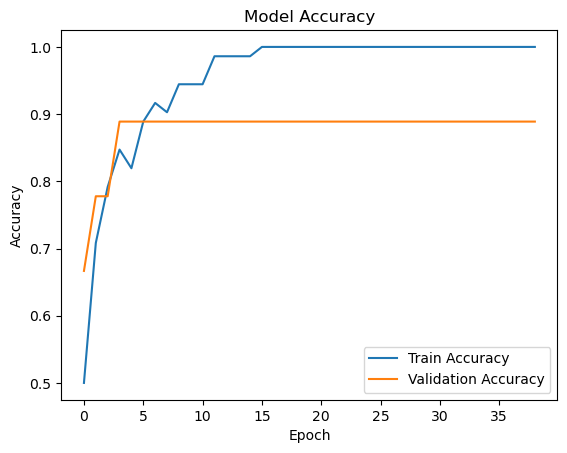

In [66]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

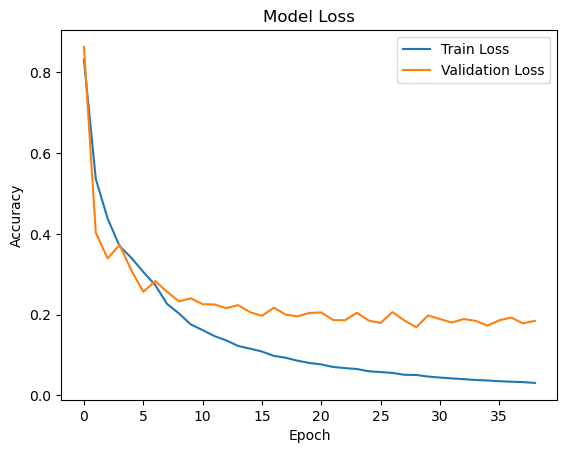

In [67]:
# Plot training & validation accuracy
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# InceptionNet

In [68]:
base_model = InceptionV3(weights='imagenet',include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce spatial dimensions
x = Dense(1024, activation='relu')(x)  # Dense layer for feature extraction
predictions = Dense(1, activation='sigmoid')(x)  # Output layer

inception_model = Model(inputs=base_model.input, outputs=predictions)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

for layer in base_model.layers:
    layer.trainable = False

inception_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [69]:
history = inception_model.fit(x_train,y_train,epochs=100,batch_size=12,validation_data=(x_val,y_val),callbacks=[early_stopping])

Epoch 1/100
6/6 [==============================] - 11s 691ms/step - loss: 10.4039 - accuracy: 0.5000 - val_loss: 6.4306 - val_accuracy: 0.6667
Epoch 2/100
6/6 [==============================] - 2s 305ms/step - loss: 5.8060 - accuracy: 0.5556 - val_loss: 9.0714 - val_accuracy: 0.3333
Epoch 3/100
6/6 [==============================] - 2s 312ms/step - loss: 2.6508 - accuracy: 0.6111 - val_loss: 4.7091 - val_accuracy: 0.5556
Epoch 4/100
6/6 [==============================] - 2s 310ms/step - loss: 1.7666 - accuracy: 0.6667 - val_loss: 1.5002 - val_accuracy: 0.5556
Epoch 5/100
6/6 [==============================] - 2s 318ms/step - loss: 0.5785 - accuracy: 0.8194 - val_loss: 1.2244 - val_accuracy: 0.5556
Epoch 6/100
6/6 [==============================] - 2s 377ms/step - loss: 0.8772 - accuracy: 0.6944 - val_loss: 1.0373 - val_accuracy: 0.6667
Epoch 7/100
6/6 [==============================] - 2s 318ms/step - loss: 0.5172 - accuracy: 0.8056 - val_loss: 2.4921 - val_accuracy: 0.6667
Epoch 8/100

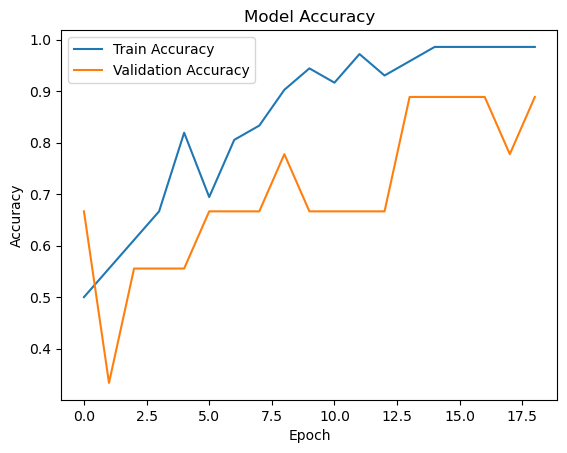

In [70]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

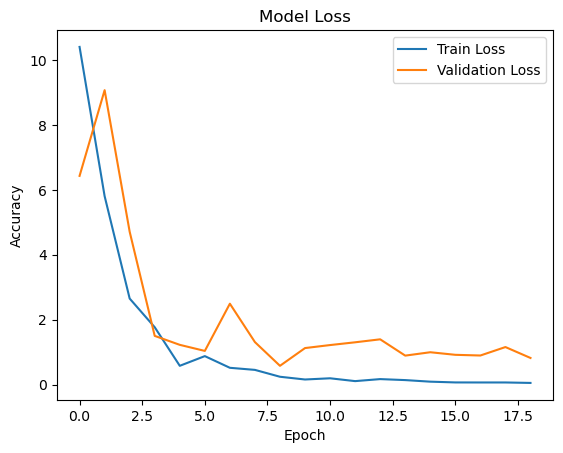

In [71]:
# Plot training & validation accuracy
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# MobileNet V3

In [72]:
base_model = MobileNetV3Large(weights='imagenet',include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce spatial dimensions
x = Dense(1024, activation='relu')(x)  # Dense layer for feature extraction
predictions = Dense(1, activation='sigmoid')(x)  # Output layer

mobilenet_model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
mobilenet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [73]:
history = mobilenet_model.fit(x_train,y_train,epochs=100,batch_size=12,validation_data=(x_val,y_val),callbacks=[early_stopping])

Epoch 1/100
6/6 [==============================] - 8s 501ms/step - loss: 0.6302 - accuracy: 0.6806 - val_loss: 0.5612 - val_accuracy: 0.7778
Epoch 2/100
6/6 [==============================] - 1s 154ms/step - loss: 0.5193 - accuracy: 0.8056 - val_loss: 0.4608 - val_accuracy: 0.7778
Epoch 3/100
6/6 [==============================] - 1s 155ms/step - loss: 0.4682 - accuracy: 0.8333 - val_loss: 0.3999 - val_accuracy: 0.7778
Epoch 4/100
6/6 [==============================] - 1s 149ms/step - loss: 0.4245 - accuracy: 0.8472 - val_loss: 0.4000 - val_accuracy: 0.7778
Epoch 5/100
6/6 [==============================] - 1s 157ms/step - loss: 0.3922 - accuracy: 0.8472 - val_loss: 0.3680 - val_accuracy: 0.7778
Epoch 6/100
6/6 [==============================] - 1s 165ms/step - loss: 0.3684 - accuracy: 0.8611 - val_loss: 0.3418 - val_accuracy: 0.8889
Epoch 7/100
6/6 [==============================] - 1s 154ms/step - loss: 0.3516 - accuracy: 0.8750 - val_loss: 0.3316 - val_accuracy: 0.8889
Epoch 8/100
6

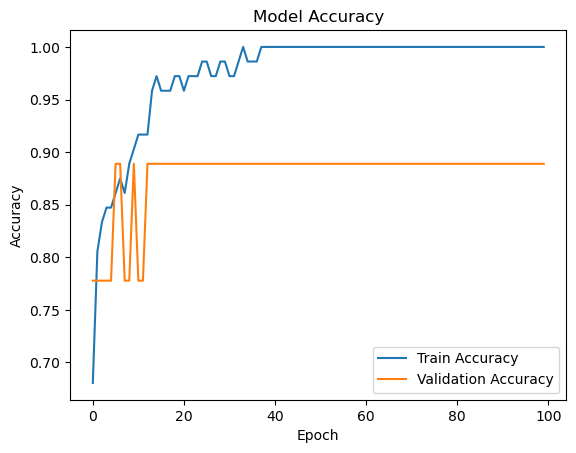

In [74]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

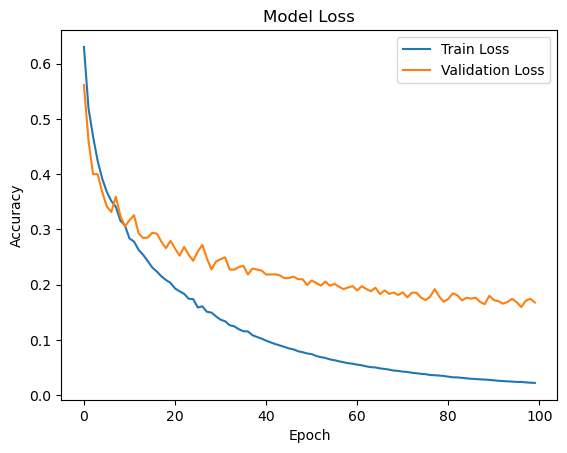

In [75]:
# Plot training & validation accuracy
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [76]:
ypreds_resnet50 = resnet50_model.predict(x_test)
ypreds_resnet152 = resnet152_model.predict(x_test)
ypreds_mobilenet = mobilenet_model.predict(x_test)
ypreds_inception = inception_model.predict(x_test)
ypreds_vgg19 = vgg_model.predict(x_test)

1/1 [==============================] - 2s 2s/step


In [77]:
ypreds_resnet50 = np.where(ypreds_resnet50>=0.5,1,0) 
ypreds_resnet152 = np.where(ypreds_resnet152>=0.5,1,0)
ypreds_mobilenet = np.where(ypreds_mobilenet>=0.5,1,0)
ypreds_inception = np.where(ypreds_inception>=0.5,1,0)
ypreds_vgg19 =np.where(ypreds_vgg19>=0.5,1,0)

# Metrics for Resnet50

In [78]:
print(f"Accuracy: {accuracy_score(y_test,ypreds_resnet50)}")
print(f"Precision: {precision_score(y_test,ypreds_resnet50)}")
print(f"Recall: {recall_score(y_test,ypreds_resnet50)}")
print(f"F1 Score: {f1_score(y_test,ypreds_resnet50)}")
print(f"ROC Score: {roc_auc_score(y_test,ypreds_resnet50)}")

Accuracy: 0.8095238095238095
Precision: 0.875
Recall: 0.7
F1 Score: 0.7777777777777777
ROC Score: 0.8045454545454546


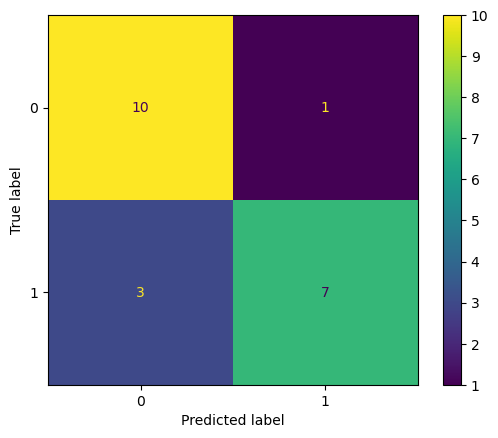

In [79]:
ConfusionMatrixDisplay(confusion_matrix(y_test,ypreds_resnet50)).plot()

# Metrics for ResNet152

In [80]:
print(f"Accuracy: {accuracy_score(y_test,ypreds_resnet152)}")
print(f"Precision: {precision_score(y_test,ypreds_resnet152)}")
print(f"Recall: {recall_score(y_test,ypreds_resnet152)}")
print(f"F1 Score: {f1_score(y_test,ypreds_resnet152)}")
print(f"ROC Score: {roc_auc_score(y_test,ypreds_resnet152)}")

Accuracy: 0.8571428571428571
Precision: 1.0
Recall: 0.7
F1 Score: 0.8235294117647058
ROC Score: 0.85


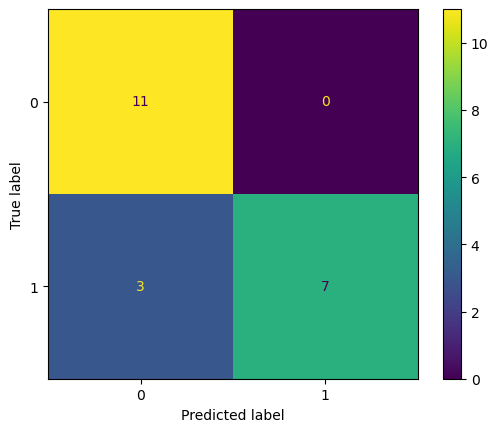

In [81]:
ConfusionMatrixDisplay(confusion_matrix(y_test,ypreds_resnet152)).plot()

# Metrics for InceptionNet

In [82]:
print(f"Accuracy: {accuracy_score(y_test,ypreds_inception)}")
print(f"Precision: {precision_score(y_test,ypreds_inception)}")
print(f"Recall: {recall_score(y_test,ypreds_inception)}")
print(f"F1 Score: {f1_score(y_test,ypreds_inception)}")
print(f"ROC Score: {roc_auc_score(y_test,ypreds_inception)}")

Accuracy: 0.7142857142857143
Precision: 0.7
Recall: 0.7
F1 Score: 0.7
ROC Score: 0.7136363636363636


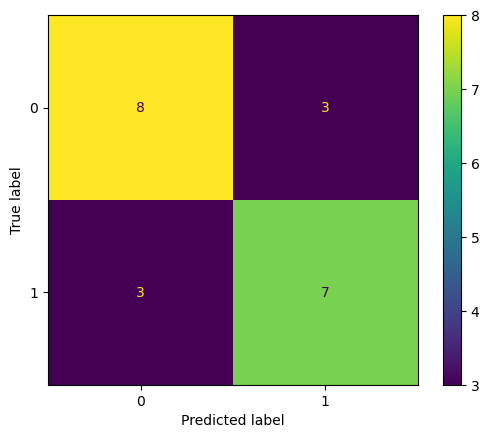

In [83]:
ConfusionMatrixDisplay(confusion_matrix(y_test,ypreds_inception)).plot()

# Metrics for VGG19

In [84]:
print(f"Accuracy: {accuracy_score(y_test,ypreds_vgg19)}")
print(f"Precision: {precision_score(y_test,ypreds_vgg19)}")
print(f"Recall: {recall_score(y_test,ypreds_vgg19)}")
print(f"F1 Score: {f1_score(y_test,ypreds_vgg19)}")
print(f"ROC Score: {roc_auc_score(y_test,ypreds_vgg19)}")

Accuracy: 0.8095238095238095
Precision: 0.875
Recall: 0.7
F1 Score: 0.7777777777777777
ROC Score: 0.8045454545454546


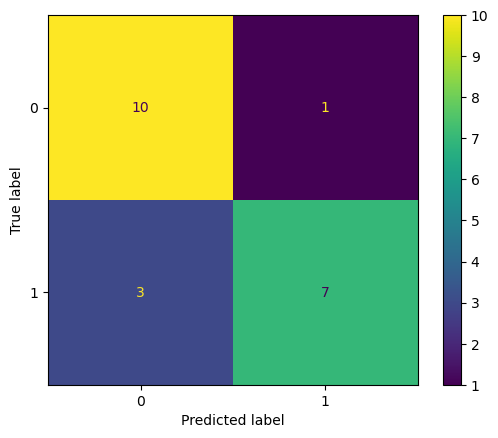

In [85]:
ConfusionMatrixDisplay(confusion_matrix(y_test,ypreds_vgg19)).plot()

# Metrics for MobileNet V3

In [86]:
print(f"Accuracy: {accuracy_score(y_test,ypreds_mobilenet)}")
print(f"Precision: {precision_score(y_test,ypreds_mobilenet)}")
print(f"Recall: {recall_score(y_test,ypreds_mobilenet)}")
print(f"F1 Score: {f1_score(y_test,ypreds_mobilenet)}")
print(f"ROC Score: {roc_auc_score(y_test,ypreds_mobilenet)}")

Accuracy: 0.7619047619047619
Precision: 0.7777777777777778
Recall: 0.7
F1 Score: 0.7368421052631577
ROC Score: 0.759090909090909


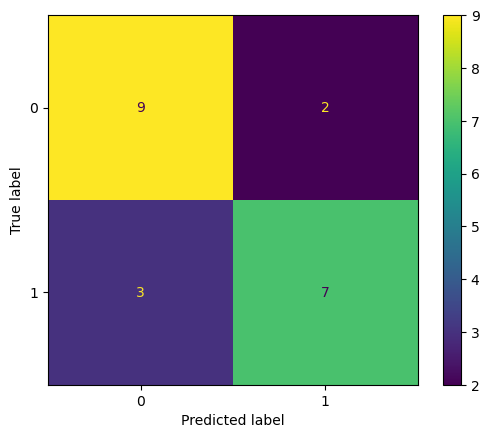

In [87]:
ConfusionMatrixDisplay(confusion_matrix(y_test,ypreds_mobilenet)).plot()